In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

In [2]:

# --- Utility Function: Biorthogonal Window ---
def biOrthogonal(window):
  L = len(window)
  biWin = np.zeros_like(window)
  for k in range(L // 2):
    row = window[k::L//2]
    H = np.zeros((1, len(row)))
    H[0, :] = row
    H_pinv = np.linalg.pinv(H)
    biWin[k::L//2] = H_pinv.ravel()
  return biWin

# --- Core RealTimeSTFT Class (Modified to be a utility container) ---
class RealTimeSTFT:
  """
  RealTimeSTFT utility container providing setup parameters and ISTFT step logic.
  We will use its methods/properties for frame-by-frame processing.
  """
  N_FFT = 1024 # Recommended window size for speed/resolution
  
  def __init__(self, fs, N_FFT=None):
    if N_FFT is not None:
        self.N_FFT = N_FFT 
    
    self.fs = fs
    current_nfft = self.N_FFT
    if N_FFT is not None: current_nfft = N_FFT 

    self.dM = int(0.5 * current_nfft) # Hop size (must be integer for slicing)
    self.win = np.hanning(current_nfft)
    self.biWin = biOrthogonal(self.win)
 
    # These attributes are only used by the plotting functions, 
    # but must be present in the object used for plotting.
    self.reconstructed = np.array([])
    self.signal = np.array([]) 

  # --- ISTFT Step logic (used for final output reconstruction) ---
  def istftStep(self, freq_frame, output_buffer):
    """
    Processes one beamformed frequency frame and performs Overlap-Add.
    Note: 'output_buffer' is passed and modified, replacing the old self.reconstructed.
    """
    if len(freq_frame) != self.N_FFT // 2:
      raise ValueError("Input frequency frame size is incorrect.")
      
    # 1. Reconstruct Full Spectrum
    sym_sample = np.concatenate((freq_frame, [0], np.conj(freq_frame[-1:0:-1])))
    
    # 2. Inverse FFT and Windowing
    # np.real() is essential as audio must be real
    step_reconstructed = np.real(np.fft.ifft(sym_sample)) * self.biWin

    # 3. Overlap-Add (Addition)
    # The current buffer's overlap region is the last N_FFT/2 samples
    output_buffer[-self.dM:] += step_reconstructed[:self.dM]
    
    # 4. Overlap-Add (Concatenation / Append the new data)
    # Append the new, non-overlapping second half of the frame
    output_buffer = np.concatenate((output_buffer, step_reconstructed[self.dM:]))
    
    return output_buffer
  
  # --- Plotting Method (RESTORED) ---
  def showReconstructed(self, original_signal):
    """
    Compares the reconstructed signal (stored in self.reconstructed) 
    with a reference signal (original_signal).
    FIXED: Uses min length to prevent ValueError during plotting.
    """
    compMargin = self.N_FFT
    
    # Ensure the reconstructed signal exists before trying to trim
    if len(self.reconstructed) == 0:
        print("Error: Reconstructed signal buffer is empty.")
        return

    # Trim the reconstructed signal to the length expected from the main function's processing loop.
    # The processing loop returns final_signal, which is trimmed as:
    # final_signal = output_buffer[start_margin:end_index] 
    # The length of the reconstructed signal (rec) is now fixed by the main loop.
    rec_processed = self.reconstructed
    
    # Trim the original signal based on the margins applied in the main loop
    # In real_time_fdbf, the raw_ch1_signal passed here is already the TRIMMED input (1/4 length).
    # We must match the length of the signal that was actually returned (final_signal).
    
    # Find the smallest valid length after accounting for the initial margin
    max_rec_length = len(rec_processed) - compMargin
    
    # Use the length of the original signal (which is the trimmed total_samples)
    final_length = min(len(original_signal), max_rec_length)
    
    # Apply trimming to both arrays to the minimum length
    rec = rec_processed[compMargin:compMargin + final_length]
    orig = original_signal[:final_length]
    
    # Check if lengths are now equal
    if len(rec) != len(orig):
         print(f"Plotting Error: Array lengths still mismatch after trimming: rec={len(rec)}, orig={len(orig)}")
         # Fallback: find the absolute minimum and trim again
         min_len = min(len(rec), len(orig))
         rec = rec[:min_len]
         orig = orig[:min_len]

    time = np.arange(len(rec)) * 1 / self.fs

    plt.figure(figsize=(10, 8))
    plt.subplot(3, 1, 1)
    plt.plot(time, rec)
    plt.title('Reconstructed Signal (FDBF Output)')
    plt.subplot(3, 1, 2)
    plt.plot(time, orig)
    plt.title('Original Signal (Channel 1)')
    plt.subplot(3, 1, 3)
    plt.plot(time, orig - rec)
    plt.title('Difference (Error)')
    plt.xlabel('Time [s]')
    plt.tight_layout()
    plt.show()


In [3]:
# --- Microphone Definitions ---
c = 343.0 
class Microphone:
  def __init__(self, id, positionM=(0, 0, 0), name=""):
    self.id = id
    self.position = positionM
    (self.x, self.y, self.z) = positionM
    self.name = name

microphones = [
    Microphone(1, positionM=(0.0995, -0.0476, 0.0068), name="lower-lens right"),
    Microphone(2, positionM=(0.1059, 0.0074, 0.0507), name="nose bridge"),
    Microphone(3, positionM=(0.0995, 0.0449, 0.0076), name="lower-lens left"),
    Microphone(4, positionM=(0.0928, 0.0641, 0.0512), name="front left"),
    Microphone(5, positionM=(0.0993, -0.0566, 0.0522), name="front right"),
    Microphone(6, positionM=(-0.0042, -0.0845, 0.0335), name="rear right"),
    Microphone(7, positionM=(-0.0048, 0.0775, 0.0349), name="rear left")
]



In [4]:

def calculate_freq_bins(fs, N_FFT):
    bin_indices = np.arange(N_FFT // 2)
    freqs = bin_indices * (fs / N_FFT)
    nyquist_freq = fs / 2
    return np.append(freqs, nyquist_freq)

def calculate_steering_vector(fs, delays_sec):
    N_FFT = RealTimeSTFT.N_FFT
    freq_bins = calculate_freq_bins(fs, N_FFT)
    omega = 2 * np.pi * freq_bins
    phase_matrix = -omega * delays_sec[:, np.newaxis] 
    W = np.exp(1j * phase_matrix)
    W_stft_size = W[:, :-1]
    return W_stft_size

# --- NEW REAL-TIME FDBF FUNCTION ---

def real_time_fdbf(data, fs, microphones, c):
    """
    Performs Frequency-Domain Delay-and-Sum Beamforming frame-by-frame 
    (mimicking real-time processing).
    Inputs:
    - data: Multichannel audio data array [num_samples, num_channels]
    - fs: Sampling frequency
    - microphones: List of Microphone objects with positions
    - c: Speed of sound in m/s
    """
    
    total_samples = data.shape[0]   
    num_channels = data.shape[1]

    
    # 1. SETUP PARAMETERS & BUFFERS
    
    # Initialize STFT utility object for windowing/hop size/ISTFT logic
    processor = RealTimeSTFT(fs=fs)
    N_FFT = processor.N_FFT
    dM = processor.dM
    
    # Input Buffers (one for each mic, holding previous samples for overlap)
    # Shape: [N_channels, N_FFT]
    input_buffers = np.zeros((num_channels, N_FFT)) 
    
    # Output Buffer (for the final reconstructed signal)
    output_buffer = np.zeros(dM) # Starts with size of one hop
    
    # Hanning Window (win)
    win = processor.win
    
    # 2. CALCULATE TIME-INVARIANT WEIGHTS (Steering Vector)
    xs = np.array([m.x for m in microphones])
    x_min = xs.min()
    delays_sec = (xs - x_min) / c      
    W_bar = calculate_steering_vector(fs, delays_sec) # Shape: [N_channels, N_bins]
    
    # 3. FRAME-BY-FRAME PROCESSING LOOP
    
    # Loop starts after the buffer is filled with the first frame (N_FFT samples)
    # We iterate over the input signal with the hop size (dM)
    N_frames = int(np.floor((total_samples - N_FFT) / dM))
    
    print(f"\nProcessing {N_frames} time frames...")
    
    # Add zero padding to the input data to process the last remaining samples
    data_padded = np.concatenate((data, np.zeros((N_FFT, num_channels))), axis=0)

    # Temporary array to hold the frequency frame for all channels
    # Shape: [N_channels, N_bins]
    X_frame_freq = np.zeros((num_channels, N_FFT // 2), dtype=complex)
    
    for t in range(N_frames):
        # Calculate start and end indices for the hop (new data)
        hop_start = t * dM
        hop_end = (t + 1) * dM
        
        # 3.1. STFT FOR ALL CHANNELS
        for ch in range(num_channels):
            # 1. Update Input Buffer: Shift old data out, bring new data in
            # This is the real-time equivalent of self.signal = np.append(self.signal, sample)
            input_buffers[ch, :-dM] = input_buffers[ch, dM:] 
            input_buffers[ch, -dM:] = data_padded[hop_start:hop_end, ch]
            
            # 2. Frame & Window: Extract N_FFT samples and apply Hanning window
            current_frame_windowed = win * input_buffers[ch, :]
            
            # 3. FFT & Trim: Perform FFT and save the unique half
            fft_result = np.fft.fft(current_frame_windowed)
            X_frame_freq[ch, :] = fft_result[:N_FFT // 2]
        
        # 3.2. BEAMFORMING (Phase Alignment & Sum)
        
        # Element-wise multiplication for phase alignment
        X_aligned = X_frame_freq * W_bar
        
        # Sum across channels (axis=0) to get one beamformed frame
        Y_beamformed_frame = X_aligned.mean(axis=0) # Shape: [N_bins]
        
        # 3.3. ISTFT & Overlap-Add
        
        # Pass the beamformed frame to the ISTFT step logic
        # The output_buffer is modified/recreated inside istftStep
        output_buffer = processor.istftStep(Y_beamformed_frame, output_buffer)

    
    # 4. FINAL OUTPUT
    # The first N_FFT samples are artifacts of the buffer start-up.
    # We also trim the end to match the original signal length.
    start_margin = N_FFT // 2
    end_index = start_margin + total_samples
    
    final_signal = output_buffer[start_margin:end_index]
    
    return final_signal, fs, data[:, 0] # Return raw channel 1 for comparison






--- Starting Real-Time (Frame-by-Frame) FDBF ---

Processing 4486 time frames...

--- FDBF Process Complete ---
Output saved to: beamformed_REAL_TIME_FDBF_output.wav


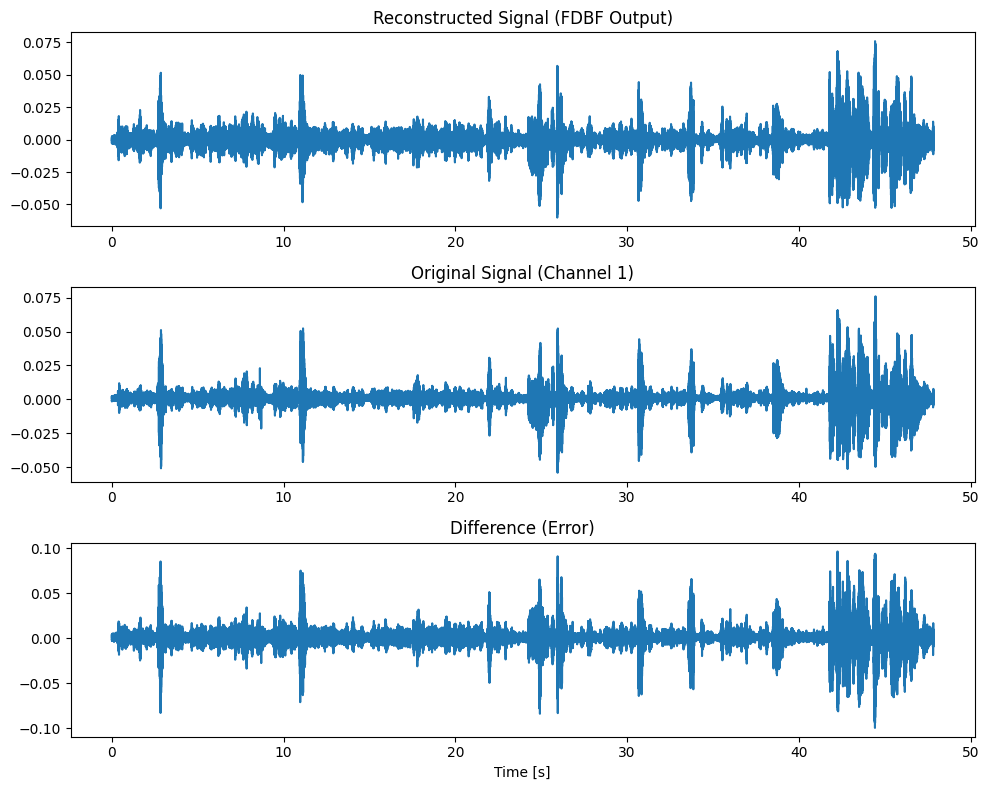

In [5]:

# --- Main Execution Block (Load data, process, save, plot) ---

input_file_path = "1117852872712786_0001_3525_22675.wav"
output_file_path = "beamformed_REAL_TIME_FDBF_output.wav"

try:
    print("--- Starting Real-Time (Frame-by-Frame) FDBF ---")
    
    data, fs = sf.read(input_file_path)

    #get only a quarter of the data for testing
    # Only use the first 1/4 of the samples for testing
    quarter_length = data.shape[0] // 4
    # Ensure the length is at least the FFT size
    if quarter_length < RealTimeSTFT.N_FFT:
        quarter_length = RealTimeSTFT.N_FFT
        
    data = data[:quarter_length, :] # Trim the input data

    # 1. Run the entire frame-by-frame process
    beamformed_signal, fs, raw_ch1_signal = real_time_fdbf(data, fs, microphones, c)
    
    # 2. Normalization and Output
    max_abs = np.max(np.abs(beamformed_signal))
    if max_abs > 0:
        beam_norm = beamformed_signal / max_abs
    else:
        beam_norm = beamformed_signal
        
    sf.write(output_file_path, beam_norm, fs)
    
    print(f"\n--- FDBF Process Complete ---")
    print(f"Output saved to: {output_file_path}")
    
    # 3. Show comparison plot
    processor = RealTimeSTFT(fs=fs) # Create a dummy processor just to use the plotting method
    
    # Need to manually assign the reconstructed signal to the object for plotting
    processor.reconstructed = beam_norm * np.max(np.abs(data[:quarter_length,0])) # Scale back for comparison
    processor.fs = fs
    processor.N_FFT = RealTimeSTFT.N_FFT # Set N_FFT for correct margin calculation in plot
    
    # We need to manually match the length of the signal for showReconstructed to work
    # We pass the full raw signal, and the plot function handles the internal trimming.
    processor.showReconstructed(raw_ch1_signal)


except FileNotFoundError:
    print(f"\nError: The file '{input_file_path}' was not found. Please ensure the file is correctly uploaded.")
except ValueError as e:
    print(f"\nError in processing: {e}")

Aligning signals... Detected lag: 17 samples


C:\Users\noash\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


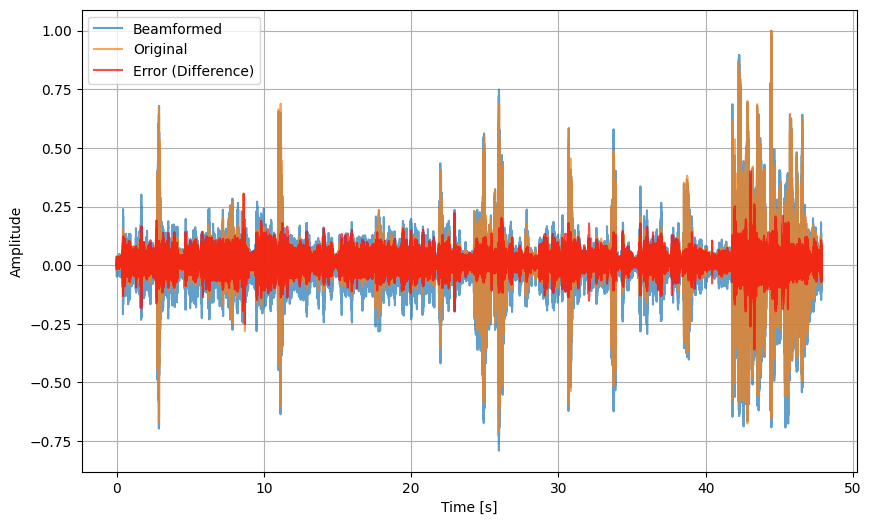

In [29]:
from scipy import signal

# 1. Normalize both signals to range [-1, 1] (Optional but recommended)
orig_norm = raw_ch1_signal / np.max(np.abs(raw_ch1_signal))
beam_norm = beamformed_signal / np.max(np.abs(beamformed_signal))

# 2. Find the time shift (lag)
correlation = signal.correlate(beam_norm, orig_norm, mode='full')
lags = signal.correlation_lags(len(beam_norm), len(orig_norm), mode='full')
lag = lags[np.argmax(correlation)]

print(f"Aligning signals... Detected lag: {lag} samples")

# 3. Shift the Original signal to match the Beamformed signal
# We use indexing instead of np.roll to avoid wrapping around edges
if lag > 0:
    # Beamformed is delayed -> shift Original to the right
    orig_aligned = np.pad(orig_norm, (lag, 0))[:len(beam_norm)]
    beam_aligned = beam_norm
elif lag < 0:
    # Original is delayed (unlikely here) -> shift Beamformed
    beam_aligned = np.pad(beam_norm, (-lag, 0))[:len(orig_norm)]
    orig_aligned = orig_norm
else:
    orig_aligned = orig_norm
    beam_aligned = beam_norm

# 4. NOW calculate the Error
error = orig_aligned - beam_aligned
time_axis = np.arange(len(beam_aligned)) / fs


# 5. Plot
plt.figure(figsize=(10, 6))
plt.plot(time_axis,beam_aligned, label="Beamformed", alpha=0.7)
plt.plot(time_axis,orig_aligned, label="Original", alpha=0.7)
plt.plot(time_axis,error, label="Error (Difference)", color='red', alpha=0.7)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()

#plt.title(f"Comparison after correcting {lag} sample lag")
plt.show()

Aligning signals... Detected lag: 17 samples
Loading RTTM file: 1117852872712786_0001_3525_22675.rttm


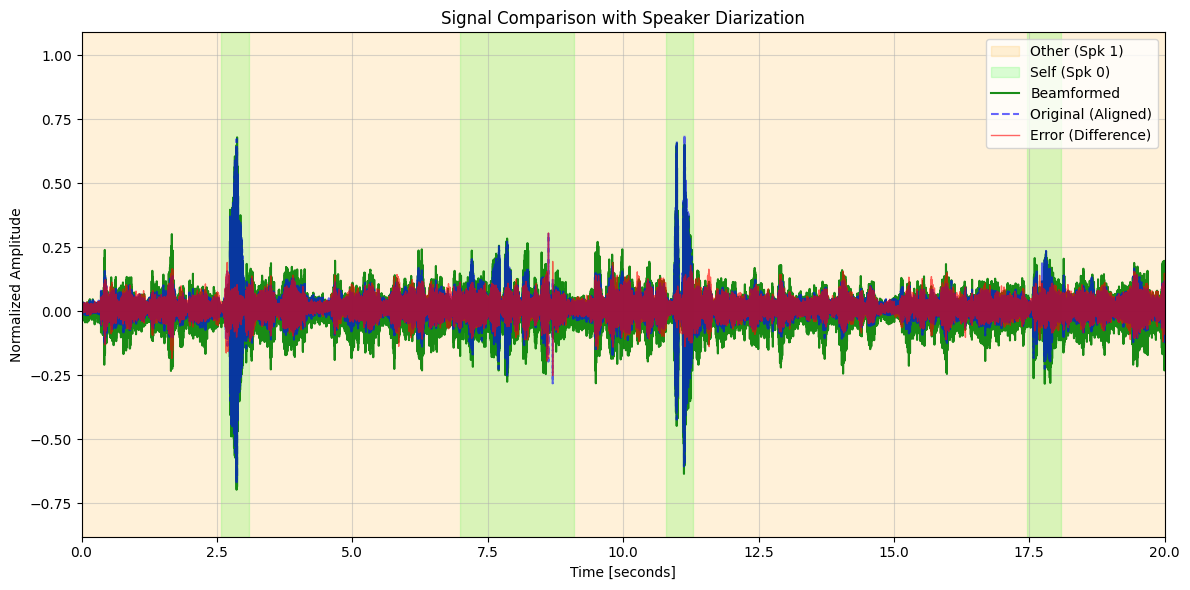

In [36]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Alignment & Normalization (Essential for Error calc) ---

# Check if 'fs' exists (sampling rate), default to 16000 if not
if 'fs' not in locals():
    fs = 16000 
    print(f"Warning: 'fs' variable not found, using default {fs} Hz")

# Normalize to range [-1, 1] to compare "Shape" instead of Gain
orig_norm = raw_ch1_signal / np.max(np.abs(raw_ch1_signal))
beam_norm = beamformed_signal / np.max(np.abs(beamformed_signal))

# Find the time shift (lag) via Cross-Correlation
correlation = signal.correlate(beam_norm, orig_norm, mode='full')
lags = signal.correlation_lags(len(beam_norm), len(orig_norm), mode='full')
lag = lags[np.argmax(correlation)]
print(f"Aligning signals... Detected lag: {lag} samples")

# Shift Original to match Beamformed
# We use indexing/padding instead of roll to avoid wrapping artifacts
if lag > 0:
    # Beamformed is delayed relative to Original -> Shift Original right
    orig_aligned = np.pad(orig_norm, (lag, 0))[:len(beam_norm)]
    beam_aligned = beam_norm
elif lag < 0:
    # Original is delayed (unlikely) -> Shift Beamformed right
    beam_aligned = np.pad(beam_norm, (-lag, 0))[:len(orig_norm)]
    orig_aligned = orig_norm
else:
    orig_aligned = orig_norm
    beam_aligned = beam_norm

# Calculate Error (Difference)
error_signal = orig_aligned - beam_aligned

# --- 2. RTTM Loading & Parsing ---
rttm_path = "1117852872712786_0001_3525_22675.rttm"
speaker_segments = []

if os.path.exists(rttm_path):
    print(f"Loading RTTM file: {rttm_path}")
    with open(rttm_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            # RTTM Format: SPEAKER <ID> 1 <start> <dur> <NA> <NA> <class> <NA> <NA>
            # We are interested in start (idx 3), dur (idx 4), and class (idx 7)
            if len(parts) >= 8 and parts[0] == 'SPEAKER':
                try:
                    start_time = float(parts[3])
                    duration = float(parts[4])
                    speaker_class = parts[7] # '0' or '1'
                    speaker_segments.append((start_time, duration, speaker_class))
                except ValueError:
                    continue
else:
    print(f"Warning: RTTM file '{rttm_path}' not found. Skipping speaker markers.")

# --- 3. Plotting ---

# Create Time Axis (Seconds)
time_axis = np.arange(len(beam_aligned)) / fs
max_plot_time = time_axis[-1] # End of the processed signal

# Calculate RTTM Offset (Seconds)
# If lag > 0, we shifted the original signal to the right by 'lag' samples.
# Since RTTM timestamps correspond to the Original signal, we must shift them too.
rttm_offset = lag / fs if lag > 0 else 0

plt.figure(figsize=(12, 6))

# Plot Speaker Segments (Background Shading)
added_labels = set()
for start, dur, spk_cls in speaker_segments:
    # Shift time to match the aligned plot
    s_plot = start + rttm_offset
    e_plot = s_plot + dur
    
    # --- CLIP SEGMENTS TO MATCH SIGNAL LENGTH ---
    # 1. If the segment starts after the signal ends, skip it entirely
    if s_plot > max_plot_time:
        continue
        
    # 2. If the segment ends after the signal ends, cut it short
    if e_plot > max_plot_time:
        e_plot = max_plot_time
    # --------------------------------------------
    
    if spk_cls == '0':
        label = "Self (Spk 0)"
        color = 'green'
        facecolor = 'lime'
    else: # spk_cls == '1'
        label = "Other (Spk 1)"
        color = 'red'
        facecolor = 'orange'
    
    # Only add label to legend once
    lbl = label if label not in added_labels else None
    added_labels.add(label)
    
    plt.axvspan(s_plot, e_plot, color=facecolor, alpha=0.15, label=lbl)

# Plot Signals
plt.plot(time_axis, beam_aligned, label="Beamformed", color='green', alpha=0.9, linewidth=1.5)
plt.plot(time_axis, orig_aligned, label="Original (Aligned)", color='blue', alpha=0.6, linestyle='--')
plt.plot(time_axis, error_signal, label="Error (Difference)", color='red', alpha=0.6, linewidth=1)

# Formatting
plt.title(f"Signal Comparison with Speaker Diarization")
plt.xlabel("Time [seconds]")
plt.ylabel("Normalized Amplitude")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.5)

#limit x axis to 20 seconds
plt.xlim(0, 20)

plt.tight_layout()
plt.show()

Aligning signals... Detected lag: 17 samples


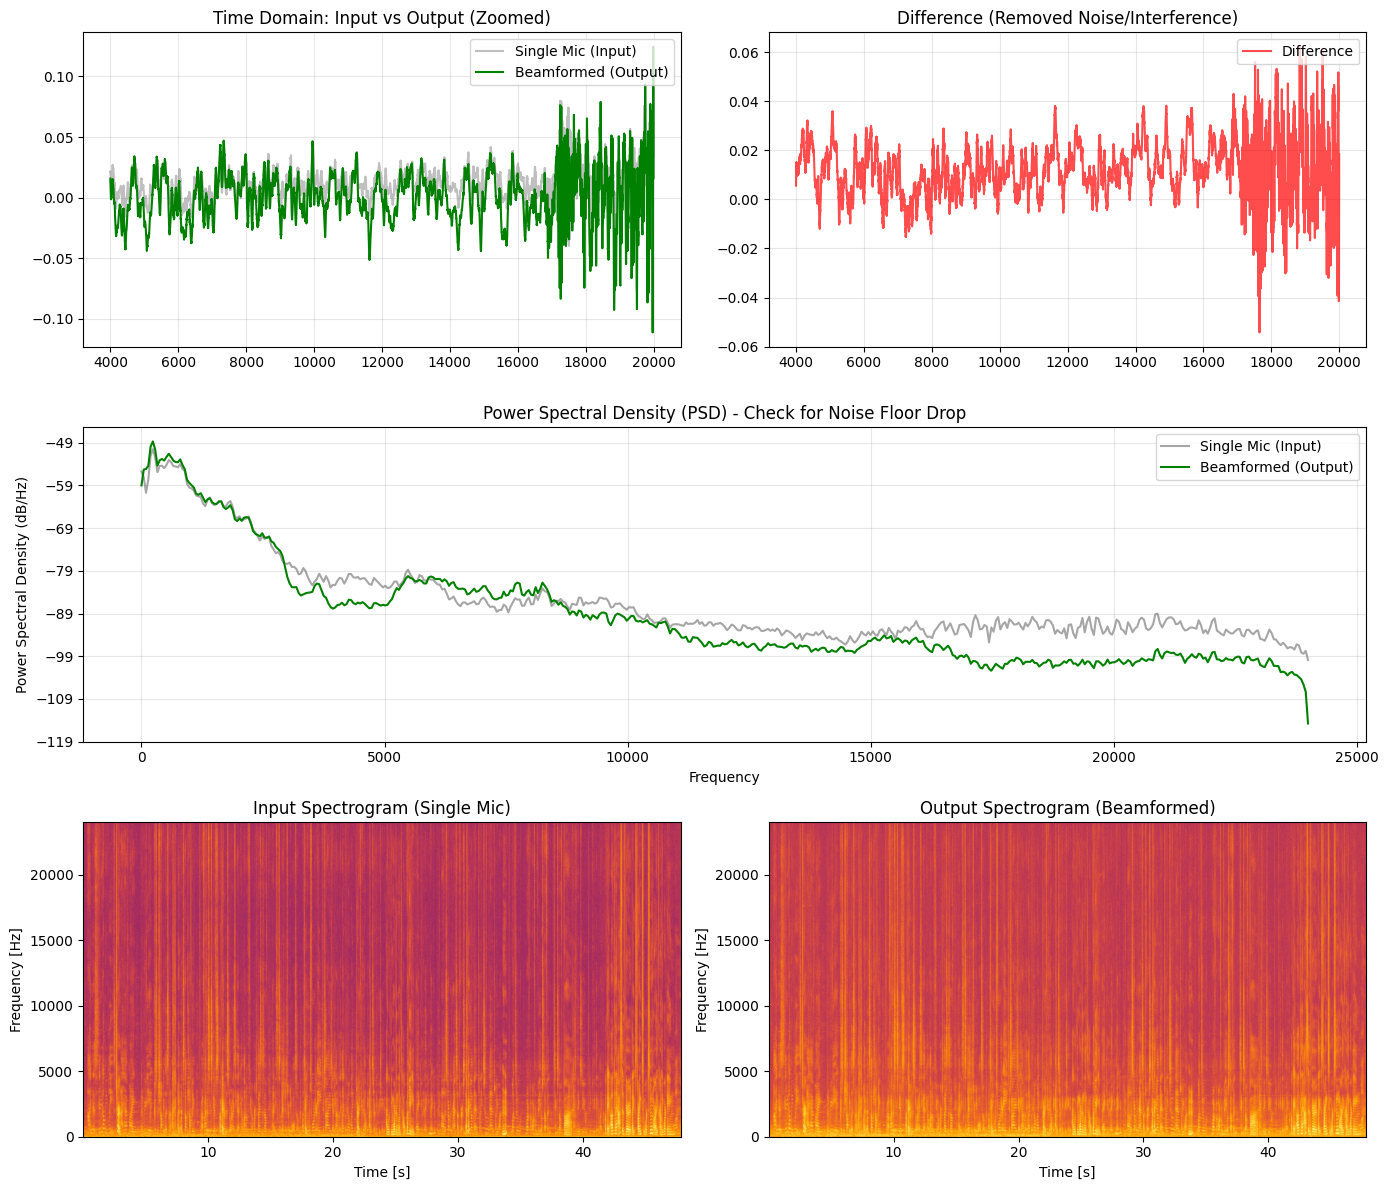

fs is  48000


In [30]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

# # --- Safety Check for Sampling Rate ---
# if 'fs' not in locals():
#     fs = 16000 # Fallback if not defined in previous cells
#     print(f"Warning: 'fs' variable not found, using default {fs} Hz")

# --- 1. Alignment & Normalization ---
# We normalize to compare the "Shape" of the signals, ignoring Gain differences.
ref_sig = raw_ch1_signal / np.max(np.abs(raw_ch1_signal))
beam_sig = beamformed_signal / np.max(np.abs(beamformed_signal))

# Find lag to align the Beamformed output with the Input
correlation = signal.correlate(beam_sig, ref_sig, mode='full')
lags = signal.correlation_lags(len(beam_sig), len(ref_sig), mode='full')
lag = lags[np.argmax(correlation)]
print(f"Aligning signals... Detected lag: {lag} samples")

# Shift Reference to match Beamformed (Visualization only)
if lag > 0:
    ref_aligned = np.pad(ref_sig, (lag, 0))[:len(beam_sig)]
    beam_aligned = beam_sig
else:
    beam_aligned = np.pad(beam_sig, (-lag, 0))[:len(ref_sig)]
    ref_aligned = ref_sig

# Calculate the difference
# In Beamforming: Difference = (Noise + Interference) that was removed
diff_signal = ref_aligned - beam_aligned

# --- 2. Visualization Dashboard ---

plt.figure(figsize=(14, 12))

# A. Time Domain (Zoomed)
# Shows how the signal waveform is preserved while noise (jitters) is reduced
start_samp = 4000
end_samp = 20000
t_slice = np.arange(start_samp, end_samp)

plt.subplot(3, 2, 1)
plt.plot(t_slice, ref_aligned[start_samp:end_samp], label="Single Mic (Input)", color='gray', alpha=0.5)
plt.plot(t_slice, beam_aligned[start_samp:end_samp], label="Beamformed (Output)", color='green', linewidth=1.5)
plt.title(f"Time Domain: Input vs Output (Zoomed)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# B. The \"Removed\" Signal
# If this looks like noise, your beamformer is working!
plt.subplot(3, 2, 2)
plt.plot(t_slice, diff_signal[start_samp:end_samp], color='red', alpha=0.7, label="Difference")
plt.title("Difference (Removed Noise/Interference)")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# C. Power Spectral Density (PSD)
# This is the most important plot for Beamforming. 
# Look for the noise floor (the lower parts of the curve) to drop.
plt.subplot(3, 1, 2)
plt.psd(ref_aligned, Fs=fs, NFFT=1024, label='Single Mic (Input)', color='gray', alpha=0.7)
plt.psd(beam_aligned, Fs=fs, NFFT=1024, label='Beamformed (Output)', color='green')
plt.title("Power Spectral Density (PSD) - Check for Noise Floor Drop")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# D. Spectrograms (Side-by-Side)
# Visual confirmation of noise cleanup across all frequencies
plt.subplot(3, 2, 5)
plt.specgram(ref_aligned, NFFT=1024, Fs=fs, noverlap=512, cmap='inferno')
plt.title("Input Spectrogram (Single Mic)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")

plt.subplot(3, 2, 6)
plt.specgram(beam_aligned, NFFT=1024, Fs=fs, noverlap=512, cmap='inferno')
plt.title("Output Spectrogram (Beamformed)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")

plt.tight_layout()
plt.show()

print("fs is ", fs)

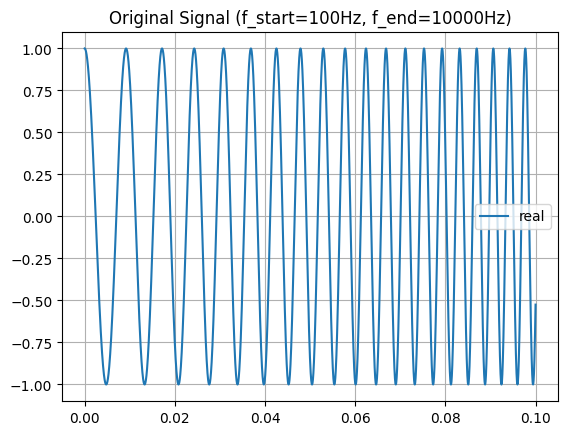

In [7]:
#synthetic sigal generation for testing
dt = 2e-5
N = 256000
t = np.arange(N) * dt
T = N * dt

f_start = 100
f_end = 10000
freq_over_time = f_start + 0.5 * t / T * (f_end - f_start)
origSig = np.real(np.exp(1j * 2 * np.pi *  freq_over_time * t))

plt.figure()
plt.plot(t[0:5000], origSig[0:5000], label='real')
plt.grid()
plt.title(f'Original Signal (f_start={f_start}Hz, f_end={f_end}Hz)')
plt.legend()
plt.show()

In [8]:
def apply_delay(x, delay_samples):
    N = len(x)
    t = np.arange(N)
    t_shifted = t - delay_samples  # y[n] = x[n - d]
    y = np.interp(t_shifted, t, x, left=0.0, right=0.0) # found this function is doing all the hard work!
    return y


In [9]:
#synthesize multichannel data with delays
xs = np.array([m.x for m in microphones])
x_min = xs.min()
delays_sec = (xs - x_min) / c      # seconds
print(delays_sec, dt)
delays_samples = delays_sec / dt   # samples (float)
print(f"delay of channel 6: {delays_samples[6]} samples")

noise_std = 0.01
microphone_synthetic = np.zeros((N, len(microphones)))

for i, mic in enumerate(microphones):
    delayed_signal = apply_delay(origSig, -delays_samples[i])

    # Generate AGWN
    noise = np.random.normal(0, noise_std, N)

    microphone_synthetic[:, i] = delayed_signal + noise

[3.04081633e-04 3.22740525e-04 3.04081633e-04 2.84548105e-04
 3.03498542e-04 1.74927114e-06 0.00000000e+00] 2e-05
delay of channel 6: 0.0 samples



Processing 498 time frames...


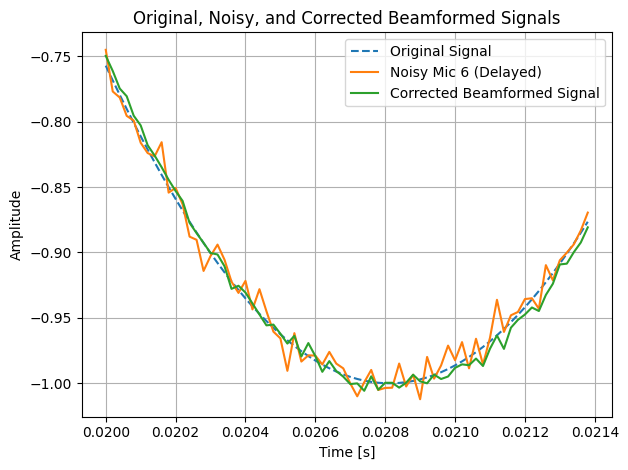

In [10]:
#calculate fdbf on synthetic data
beamformed_signal_synth, fs_synth, raw_ch1_signal_synth = real_time_fdbf(microphone_synthetic, 1/dt, microphones, c)

plt.figure()
segmentN2_begin = 1000
segmentN2_end = 1070
# original synthetic signal
plt.plot(t[segmentN2_begin:segmentN2_end], origSig[segmentN2_begin:segmentN2_end], label='Original Signal', linestyle='--')

# noisy mic recording
plt.plot(t[segmentN2_begin:segmentN2_end], microphone_synthetic[segmentN2_begin:segmentN2_end, 6], label='Noisy Mic 6 (Delayed)')

# corrected beamformed signal
plt.plot(t[segmentN2_begin:segmentN2_end], beamformed_signal_synth[segmentN2_begin:segmentN2_end], label='Corrected Beamformed Signal')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original, Noisy, and Corrected Beamformed Signals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Detected Lag: 0 samples


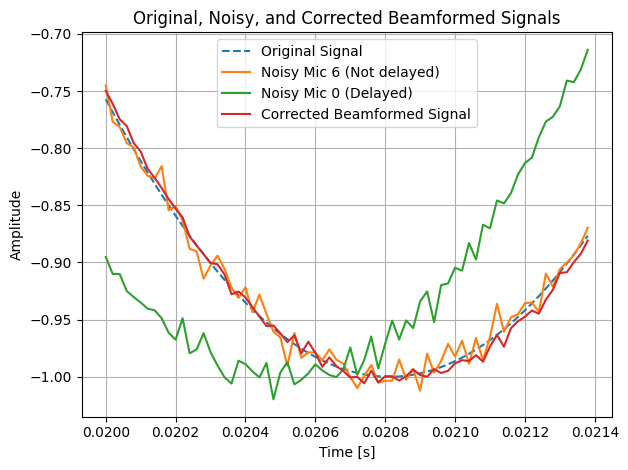

In [11]:
from scipy import signal

# 1. Calculate the lag
correlation = signal.correlate(beamformed_signal_synth, origSig, mode='full')
lags = signal.correlation_lags(len(beamformed_signal_synth), len(origSig), mode='full')
lag = lags[np.argmax(correlation)]

print(f"Detected Lag: {lag} samples")

# 2. Shift the Original Signal to match the Beamformed one for plotting
# (This simulates the propagation delay on the original signal)
origSig_shifted = np.roll(origSig, lag)
#shift the microphone_synthetic as well
microphone_synthetic_shifted = np.zeros_like(microphone_synthetic)
for i in range(microphone_synthetic.shape[1]):
    microphone_synthetic_shifted[:, i] = np.roll(microphone_synthetic[:, i], lag)

# Plot
plt.plot(t[segmentN2_begin:segmentN2_end], origSig_shifted[segmentN2_begin:segmentN2_end], label='Original Signal', linestyle='--')

# noisy mic recording
plt.plot(t[segmentN2_begin:segmentN2_end], microphone_synthetic_shifted[segmentN2_begin:segmentN2_end, 6], label='Noisy Mic 6 (Not delayed)')
plt.plot(t[segmentN2_begin:segmentN2_end], microphone_synthetic_shifted[segmentN2_begin:segmentN2_end, 0], label='Noisy Mic 0 (Delayed)')

# corrected beamformed signal
plt.plot(t[segmentN2_begin:segmentN2_end], beamformed_signal_synth[segmentN2_begin:segmentN2_end], label='Corrected Beamformed Signal')

plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Original, Noisy, and Corrected Beamformed Signals')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()